In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import discriminability
import scipy.stats

In [2]:
def ellipses_and_measure(mu0, sigma0, mu1, sigma1):
    discriminability.plot_ellipses(mu0, sigma0, mu1, sigma1)
    print('Jeffreys:', discriminability.mv_normal_jeffreys(mu0, sigma0, mu1, sigma1))

def null_model_example(null_func):
    mu0 = np.array([1., .5])
    mu1 = np.array([.5, 1.])
    sigma0 = np.array([[1.5, 1.], [1., 1.5]])
    sigma1 = np.array([[1.5, 1.], [1., 1.5]])
    ellipses_and_measure(*null_func(mu0, sigma0),
                         *null_func(mu1, sigma1))

Jeffreys: 0.5


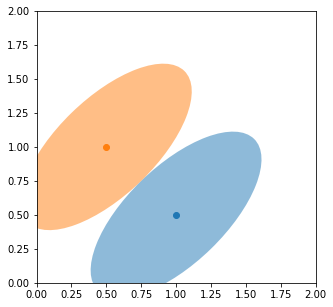

In [3]:
mu0 = np.array([1., .5])
mu1 = np.array([.5, 1.])
sigma0 = np.array([[1.5, 1.], [1., 1.5]])
sigma1 = np.array([[1.5, 1.], [1., 1.5]])
ellipses_and_measure(mu0, sigma0, mu1, sigma1)

## Simple null model: set off-diagonal elements of covariance to zero
For data, we can instead shuffle the data within each component, which should give the same effect for large numbers of data.

In [4]:
def erase_offdiag(mu, sigma):
    """mu is ignored, just there for consistent syntax"""
    return mu, np.diag(np.diag(sigma))

def shuffle_data(x):
    return np.vstack([np.random.permutation(x[:,ii]) for ii in range(x.shape[1])]).T

Jeffreys: 0.16666666666666674


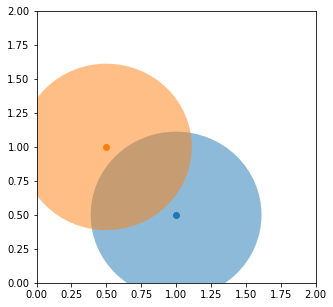

In [5]:
null_model_example(erase_offdiag)

## set off-diagonal components to zero, then scale covariance matrix to fix determinant
This preserves the entropy of the distribution. 

In [6]:
def diag_and_scale(mu, sigma):
    det = np.linalg.det(sigma)
    diag = np.diag(sigma)
    newdet = np.prod(diag)
    diagmat = np.diag(diag)
    size = sigma.shape[0]
    factor = (det / newdet)**(1/size)
    return mu, factor*diagmat

Jeffreys: 0.22360679774997894


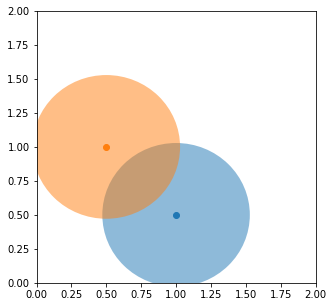

In [7]:
null_model_example(diag_and_scale)

## aggregate over many random rotations of each sigma

In [8]:
def rotate(M, theta):
    """Just the 2D case for now."""
    rotmat = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    return rotmat.dot(M).dot(rotmat.T)

def random_rotation(mu, sigma):
    theta = np.random.uniform(0,2*np.pi)
    return mu, rotate(sigma, theta)

Jeffreys: 0.197010836688


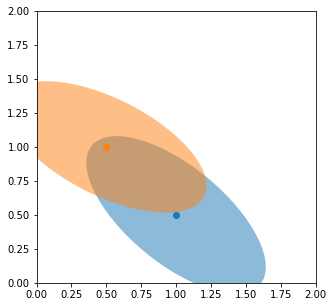

In [92]:
null_model_example(random_rotation)

Jeffreys: 1.44101704427


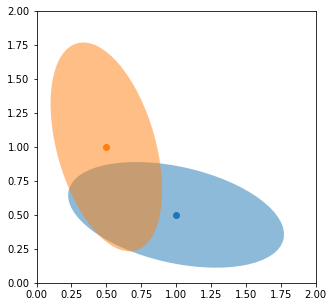

In [87]:
null_model_example(random_rotation)

In [94]:
nsamples = 10000
jeffreys = np.zeros(nsamples)
for ii in range(nsamples):
    rot0 = random_rotation(mu0, sigma0)
    rot1 = random_rotation(mu1, sigma1)
    jeffreys[ii] = discriminability.mv_normal_jeffreys(*rot0, *rot1)

In [9]:
def rot_plot(mu0, sigma0, mu1, sigma1, measure, nsamples=10000):
    values = np.zeros(nsamples)
    for ii in range(nsamples):
        rot0 = random_rotation(mu0, sigma0)
        rot1 = random_rotation(mu1, sigma1)
        values[ii] = measure(*rot0, *rot1)
    fig, ax = plt.subplots(1,1)
    vals, bins, patches = ax.hist(values, bins=50, density=True)
    original = measure(mu0, sigma0, mu1, sigma1)
    ax.vlines(original, 0, np.max(vals))

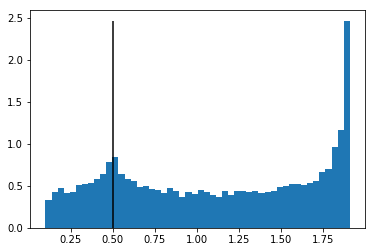

In [10]:
rot_plot(mu0, sigma0, mu1, sigma1, discriminability.mv_normal_jeffreys)

## generalize to higher dimensions

In [68]:
def random_rotation(mu, sigma):
    rotmat = scipy.stats.special_ortho_group.rvs(sigma.shape[0])
    return mu, rotmat.dot(sigma).dot(rotmat.T)

def histo_samples(orig0, orig1, trans, measure, nsamples):
    values = np.zeros(nsamples)
    for ii in range(nsamples):
        new0 = trans(orig0)
        new1 = trans(orig1)
        values[ii] = measure(new0, new1)
    fig, ax = plt.subplots(1,1)
    vals, bins, patches = ax.hist(values, bins=50, density=True)
    orig_val = measure(orig0, orig1)
    ax.vlines(orig_val, 0, np.max(vals))
    
    frac_less = np.count_nonzero(orig_val > values)/nsamples
    return orig_val, frac_less

def rot_plot(mu0, sigma0, mu1, sigma1, measure, nsamples=10000):
    def unpack_rot(args):
        return random_rotation(*args)
    def unpack_measure(arg0, arg1):
        return measure(*arg0, *arg1)
    val, frac = histo_samples((mu0, sigma0), (mu1, sigma1), unpack_rot, unpack_measure, nsamples)
    print('Value: ', val)
    print('Fraction of rotations giving smaller values: ', frac)

Value:  0.5
Fraction of rotations giving smaller values:  0.2025


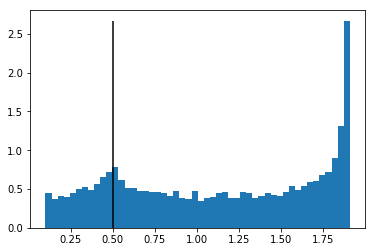

In [69]:
rot_plot(mu0, sigma0, mu1, sigma1, discriminability.mv_normal_jeffreys)

In [22]:
mu2 = np.array([1, 0.5, 0.3])
mu3 = np.array([0.5, 1, 0.8])
sigma2 = np.array([[1.5, 1., 0.5],
                   [1., 1.5, 1.2],
                   [0.5, 1.2, 1.5]])
sigma3 = sigma2.copy()

Value:  0.5462962962962967
Fraction of rotations giving smaller values:  0.0016


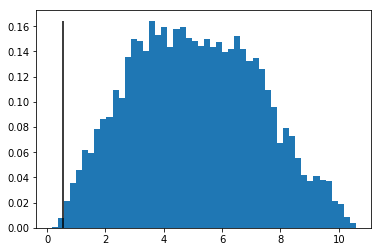

In [70]:
rot_plot(mu2, sigma2, mu3, sigma3, discriminability.mv_normal_jeffreys)

Value:  5.125065211693446
Fraction of rotations giving smaller values:  0.519


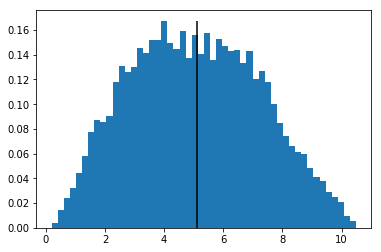

In [71]:
rot_plot(*random_rotation(mu2, sigma2),
         *random_rotation(mu3, sigma3), 
         measure = discriminability.mv_normal_jeffreys)

Value:  0.48424335083133996
Fraction of rotations giving smaller values:  0.3239


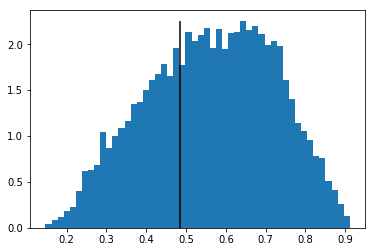

In [72]:
rot_plot(*random_rotation(mu2, np.diag([1,2,3])),
         *random_rotation(mu3, np.diag([1,2,3])),
        measure = discriminability.mv_normal_jeffreys)

Value:  0.8638739405266822
Fraction of rotations giving smaller values:  0.9596


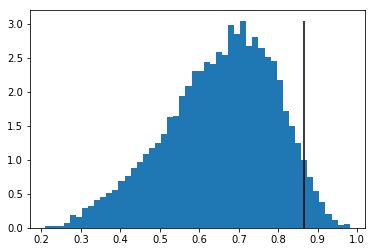

In [73]:
rot_plot(*random_rotation(np.array([1, 0.5, 0.3, 0.8]), np.diag([1,2,3,2.5])),
         *random_rotation(np.array([0.5, 1, 0.8, 0.3]), np.diag([1,2,3, 2.5])),
        measure = discriminability.mv_normal_jeffreys)

## calculations from data instead of known mv gaussian parameters

In [80]:
nsamples = 100 # for each gaussian
rng = np.random.RandomState(3312018)
x2d = rng.multivariate_normal(mu0, sigma0, size=nsamples)
y2d = rng.multivariate_normal(mu1, sigma1, size=nsamples)
x3d = rng.multivariate_normal(mu2, sigma2, size=nsamples)
y3d = rng.multivariate_normal(mu3, sigma3, size=nsamples)

In [55]:
def ellipses_and_measure_normal_data(x0, x1):
    mu0 = x0.mean(0)
    sigma0 = np.cov(x0)
    mu1 = x1.mean(0)
    sigma1 = np.cov(x1)
    discriminability.plot_ellipses(mu0, sigma0, mu1, sigma1)
    print('Jeffreys:', discriminability.mv_normal_jeffreys(mu0, sigma0, mu1, sigma1))

def scatter_and_measure(x0, x1):
    fig, ax = plt.subplots(1,1)
    c0, c1 = u'#1f77b4', u'#ff7f0e'
    ax.plot(x0[:,0], x0[:,1], '.', color=c0)
    ax.plot(x1[:,0], x1[:,1], '.', color=c1)
    print('Jeffreys:', discriminability.mv_normal_jeffreys_data(x0, x1))
    print('Linear discriminability', discriminability.linear_discriminability_data(x0, x1))
    print('Quadratic disciminability', discriminability.qda_data(x0, x1))

Jeffreys: 0.3966893471854558
Linear discriminability 0.6569877358826653
Quadratic disciminability 0.665


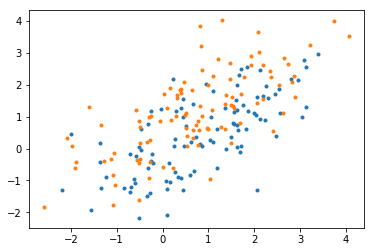

In [60]:
scatter_and_measure(x2d, y2d)

I think the finite-sample calculations consistently underestimate. Using more samples increases the estimate.

## Simple null model: shuffle data

Jeffreys: 0.19963678873151647
Linear discriminability 0.32258095260985975
Quadratic disciminability 0.61


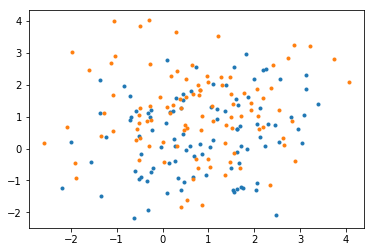

In [62]:
scatter_and_measure(shuffle_data(x2d), shuffle_data(y2d))

In [78]:
def shuffle_plot_data(x0, x1, measure, ntrials=1000):
    val, frac = histo_samples(x0, x1, shuffle_data, measure, ntrials)
    print('Value:', val)
    print('Fraction of shuffles giving smaller values: ', frac)

Value: 0.3966893471854558
Fraction of shuffles giving smaller values:  1.0


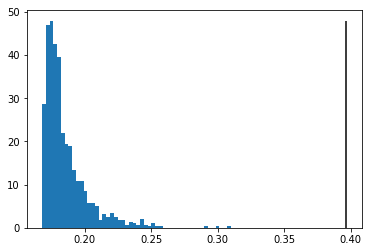

In [79]:
shuffle_plot_data(x2d, y2d, discriminability.mv_normal_jeffreys_data, 1000)

Value: 0.5738203038086347
Fraction of shuffles giving smaller values:  1.0


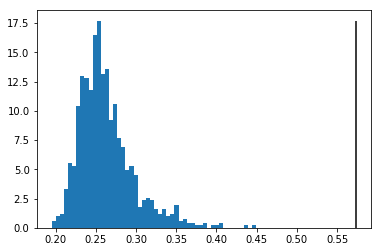

In [81]:
shuffle_plot_data(x3d, y3d, discriminability.mv_normal_jeffreys_data, 1000)

Not sure if there's an analogous thing to do that preserves entropy

## random rotations

In [85]:
def random_rotation_data(xx):
    mu = np.mean(xx, keepdims=True)
    centered = xx - mu
    rotmat = scipy.stats.special_ortho_group.rvs(xx.shape[1])
    return centered.dot(rotmat.T) + mu

def rot_plot_data(x0, x1, measure, nsamples=10000):
    val, frac = histo_samples(x0, x1, random_rotation_data, measure, nsamples)
    print('Value: ', val)
    print('Fraction of rotations giving smaller values: ', frac)

Value:  0.3966893471854558
Fraction of rotations giving smaller values:  0.1882


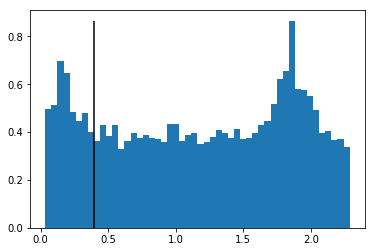

In [87]:
rot_plot_data(x2d,
         y2d,
        measure = discriminability.mv_normal_jeffreys_data)

Value:  0.462486221290095
Fraction of rotations giving smaller values:  0.2111


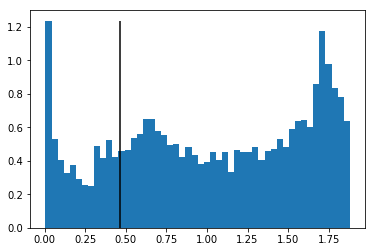

In [89]:
nsamples = 1000 # for each gaussian
rng = np.random.RandomState(3312018)
x2dbig = rng.multivariate_normal(mu0, sigma0, size=nsamples)
y2dbig = rng.multivariate_normal(mu1, sigma1, size=nsamples)
rot_plot_data(x2dbig,
         y2dbig,
        measure = discriminability.mv_normal_jeffreys_data)

Value:  0.5
Fraction of rotations giving smaller values:  0.2082


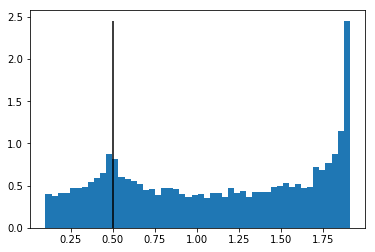

In [88]:
# for comparison
rot_plot(mu0, sigma0, mu1, sigma1, discriminability.mv_normal_jeffreys)

Value:  0.5738203038086347
Fraction of rotations giving smaller values:  0.0045


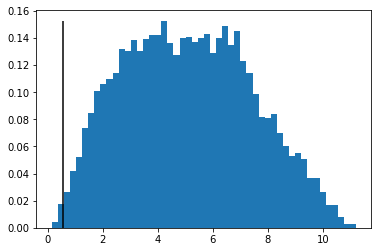

In [91]:
rot_plot_data(x3d,
         y3d,
        measure = discriminability.mv_normal_jeffreys_data)